<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session9/S9_Neha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !git clone https://github.com/MittalNeha/vision_pytorch.git

In [4]:
# !rm -rf /content/vision_pytorch/

In [5]:
# !pip install --upgrade albumentations

In [6]:
# %cd /content/drive/MyDrive/EVA6/VisionRepo/

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch 
from torchvision import datasets, transforms
from torchsummary import summary

from vision_pytorch.models import custom_resnet
from vision_pytorch.main import *
from vision_pytorch.utils import *
from vision_pytorch.models.lrfinder import *

In [8]:
# import vision_pytorch

In [9]:
# import importlib 
# importlib.reload(vision_pytorch.models)
# from vision_pytorch.models import custom_resnet

In [10]:
# importlib.reload(vision_pytorch.main)
# from vision_pytorch.main import *

In [11]:
trainset, testset = download_data()

Files already downloaded and verified
Files already downloaded and verified


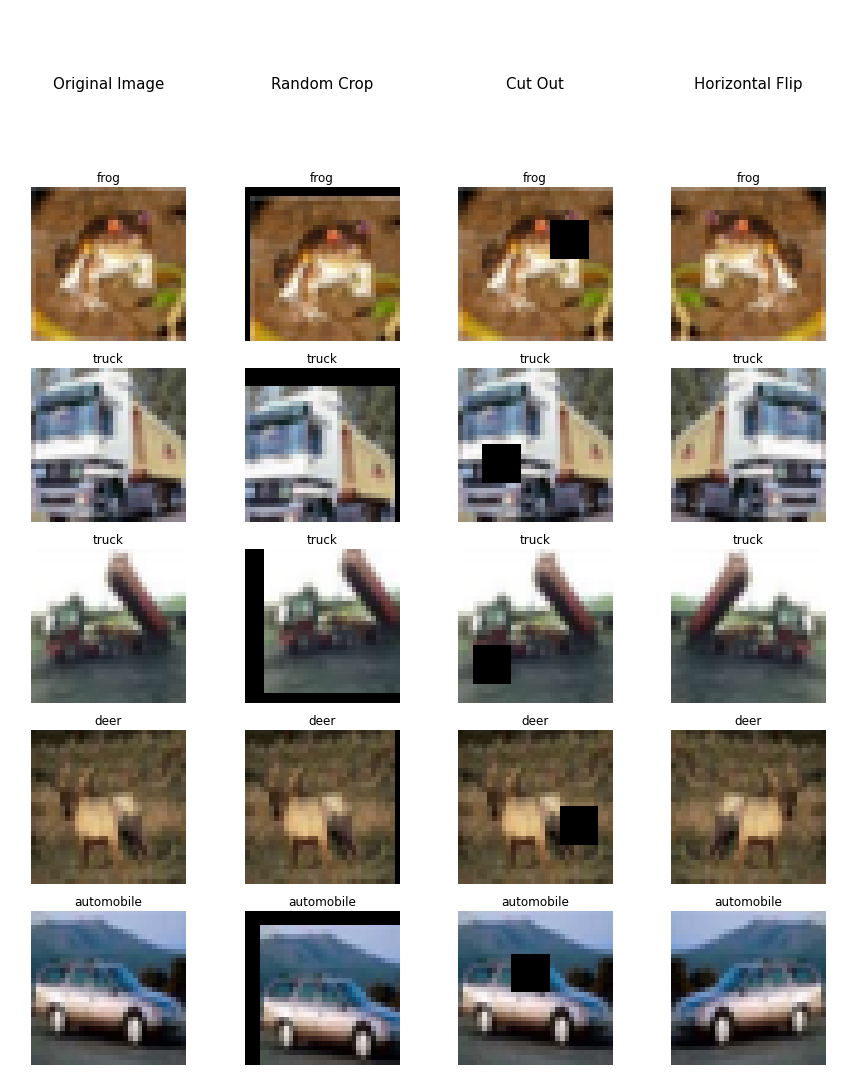

In [12]:
plot_aug({
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, 
                               min_width=8, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Horizontal Flip': A.HorizontalFlip(always_apply=True)
}, data=trainset)

In [13]:
train_transform = A.Compose(
    {
        A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
     A.Sequential([
                   A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by defaulf
                   A.RandomCrop(32,32)
                   ]),
     A.HorizontalFlip(),
     A.CoarseDropout(1, 8, 8, 1, 8, 8,fill_value=0.473363, mask_fill_value=None)
     }
     )

test_transform = A.Compose({
  A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
})

In [14]:
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=32
    
print(f'Batch Size: {BATCH_SIZE}')

CUDA Available: True
Batch Size: 512


In [15]:
train_loader = torch.utils.data.DataLoader(LoadDataset(trainset, train_transform), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(LoadDataset(testset, test_transform), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [17]:
net = custom_resnet.customResnet()
net = net.to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
            Conv2d-6          [-1, 128, 16, 16]         147,456
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
       BasicBlock-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         294,912
        MaxPool2d-12            [-1, 256, 8, 8]               0
      BatchNorm2d-13            [-1, 256, 8, 8]             512
       BasicBlock-14            [-1, 25

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Learning rate search finished. See the graph with {finder_name}.plot()


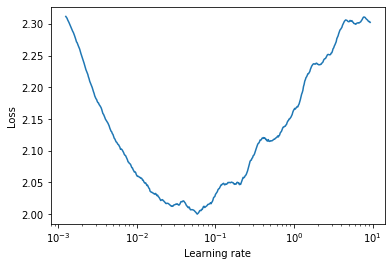

In [18]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2, steps_per_epoch=len(train_loader), 
#                                                  epochs=25, anneal_strategy='linear')

criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=500)
lr_finder.plot()  

In [19]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.05861381645140288


#Train the model

In [20]:
net = custom_resnet.customResnet()
net = net.to(device)

In [21]:

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=ler_rate, steps_per_epoch=len(train_loader), 
                                                 epochs=24,pct_start=0.2, div_factor=10,  three_phase=False, verbose=False, final_div_factor=100,
                                                anneal_strategy='linear') #final_div_factor=10,
net, history = fit_model(
    net=net, device=device,
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1




Test set: Average loss: 2.0985, Accuracy: 4628/10000 (46.28%)

EPOCH: 2




Test set: Average loss: 2.0220, Accuracy: 5386/10000 (53.86%)

EPOCH: 3




Test set: Average loss: 1.9504, Accuracy: 6079/10000 (60.79%)

EPOCH: 4




Test set: Average loss: 1.9284, Accuracy: 6268/10000 (62.68%)

EPOCH: 5




Test set: Average loss: 1.9453, Accuracy: 6114/10000 (61.14%)

EPOCH: 6




Test set: Average loss: 1.8667, Accuracy: 6853/10000 (68.53%)

EPOCH: 7




Test set: Average loss: 1.8514, Accuracy: 6996/10000 (69.96%)

EPOCH: 8




Test set: Average loss: 1.8464, Accuracy: 7064/10000 (70.64%)

EPOCH: 9




Test set: Average loss: 1.8540, Accuracy: 6993/10000 (69.93%)

EPOCH: 10




Test set: Average loss: 1.8355, Accuracy: 7163/10000 (71.63%)

EPOCH: 11




Test set: Average loss: 1.8257, Accuracy: 7267/10000 (72.67%)

EPOCH: 12




Test set: Average loss: 1.8562, Accuracy: 6964/10000 (69.64%)

EPOCH: 13




Test set: Average loss: 1.8238, Accuracy: 7260/10000 (72.60%)

EPOCH: 14




Test set: Average loss: 1.7847, Accuracy: 7658/10000 (76.58%)

EPOCH: 15




Test set: Average loss: 1.7853, Accuracy: 7639/10000 (76.39%)

EPOCH: 16




Test set: Average loss: 1.7912, Accuracy: 7596/10000 (75.96%)

EPOCH: 17




Test set: Average loss: 1.7707, Accuracy: 7784/10000 (77.84%)

EPOCH: 18




Test set: Average loss: 1.7694, Accuracy: 7794/10000 (77.94%)

EPOCH: 19




Test set: Average loss: 1.7633, Accuracy: 7864/10000 (78.64%)

EPOCH: 20




Test set: Average loss: 1.7614, Accuracy: 7868/10000 (78.68%)

EPOCH: 21




Test set: Average loss: 1.7550, Accuracy: 7924/10000 (79.24%)

EPOCH: 22




Test set: Average loss: 1.7552, Accuracy: 7924/10000 (79.24%)

EPOCH: 23




Test set: Average loss: 1.7472, Accuracy: 8001/10000 (80.01%)

EPOCH: 24




Test set: Average loss: 1.7454, Accuracy: 8026/10000 (80.26%)



Collect the learning rate used for training and plot

In [30]:
len(history[4])

2352

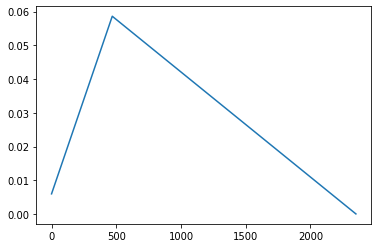

In [22]:
lr_hist = history[4][0]
for i in range(1, len(history[4])):
    lr_hist.extend(history[4][i])
plt.plot(lr_hist)

In [23]:
history_34 = history

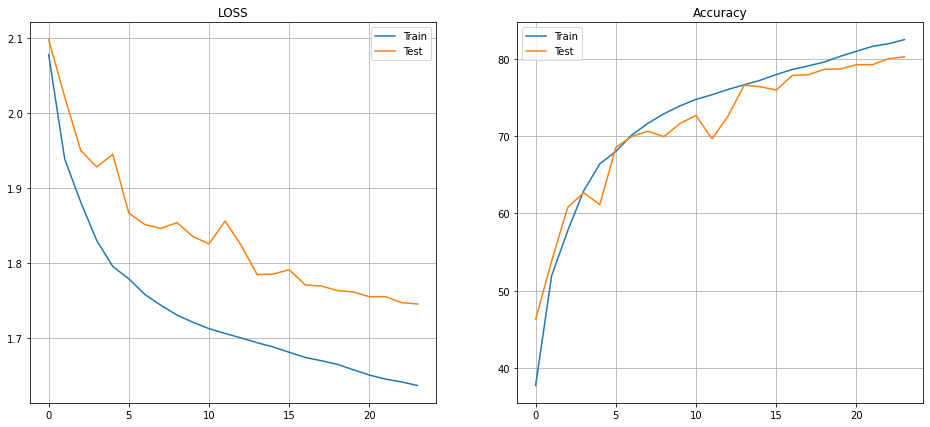

In [24]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history_34[1], label='Train')
axs[0].plot(history_34[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history_34[0], label='Train')
axs[1].plot(history_34[2], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

In [ ]:
net_18.load_state_dict(torch.load("resnet18.pt"))

In [ ]:
net_18.eval()
img,lab = test_loader.dataset[100]
img = img.unsqueeze(0).to(device)
pred = net_18(img)

In [ ]:
pred,lab

In [ ]:
pred.shape

In [ ]:
mean, std = np.array([0.49139968, 0.48215841, 0.44653091]), np.array([0.24703223, 0.24348513, 0.26158784])
wrong_pred = plot_misclassified(net_18, test_loader, testset.classes, device, mean, std, return_misclf=True)

In [ ]:
mean, std = np.array([0.49139968, 0.48215841, 0.44653091]), np.array([0.24703223, 0.24348513, 0.26158784])
wrong_pred = plot_misclassified(net_34, test_loader, testset.classes, device, mean, std, return_misclf=True)